In [59]:
import xarray as xr
from matplotlib import pyplot as plt
import rioxarray as rx
import numpy as np
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
import dask

In [23]:
from dask.distributed import Client

In [60]:
 # S-1 Backscatter Dataset
BS = xr.open_dataset('/disk/scratch/local.4/harry/S1/full_nc/COMBINED.nc',chunks={'t':87,'lat':1500,'lon':1500})
#-------------------------------------------------------------------
#-------------------------------------------------------------------
Rdrive='/exports/csce/datastore/geos/users/s1332488/chapter2_data/'
# Import Forest Cover Data (Sentinel 2020)
#forest = rx.open_rasterio(Rdrive+'Ivindo_ForestCover.tif').rename({'x':'lon','y':'lat'}).sel(band=1).drop('band')

# Get rid of bits with uneven numbers of observations
BS = BS.where(BS.VV.count(dim='t') == BS.t.size)
# Get rid of NonForest Straight away
#BS = BS.where(forest.interp_like(BS,method='linear') == 1) 

# Variable N is size of temporal kernel to be used
# Use this to select appropriate data for UAV time period
N = 30
start_date, end_date = datetime(2020,1,1), datetime(2021,1,1)
data_start = start_date - timedelta(days = 12*N + 1)
data_end = end_date + timedelta(days = 12*N + 1)
print(data_start,'  UNTIL   ',data_end)
#BS = BS.sortby('t').sel(t=slice(data_start,data_end))

2019-01-05 00:00:00   UNTIL    2021-12-28 00:00:00


In [44]:
def convolve(band,N):
    """
    Takes either VV or VH band and performs convolutions to search for step decrease in backscatter
    N is the size of the kernel - larger is more reliable but requires more data
    Experiment suggests setting N to 30 is effective, 
    --> this means one year of data either side of the study period is required
    The length of the output is T - 2(N-1) if T is the original timeseries length
    Large values in the output indicate:
    --> A more clearly defined drop in backscatter with stable periods either side
    --> And/or a larger relative drop in backscatter 
    """
    kernel = xr.DataArray(np.concatenate([np.ones(N//2),-np.ones(N//2)]),dims=['kt'])
    conv1 = band.rolling(t=N,center=True).construct(t='kt').dot(kernel)
    relu = np.maximum(conv1, 0)
    triangle = np.concatenate([np.linspace(0,0.99,N//2),np.flip(np.linspace(0,0.99,N//2))])
    kernel2 = xr.DataArray(triangle,dims=['kt'])
    conv2 = relu.rolling(t=N,center=True).construct(t='kt').dot(kernel2)
    return conv2

def model(ds,N=30,NN=20):
    """
    model takes dataset ds (with non-forest masked already), containing VV and VH timeseries
    Timeseries should span a year on either side of the study period
    -- N (time kernel) is fixed to 30
    -- NN (spatial output size) is fixed to 20, i.e. 200m x 200m pixels are output
    -- C is a threshold parameter that is subtracted from the disturbance index
    -- M is scaling factor which multiplies the disturbance index
    outputs 
    """
    ds = ds.sortby('t')
    vv, vh = convolve(ds.VV,N), convolve(ds.VH,N)
    shadow = np.sqrt(vv*vh).max(dim='t')
    shadow = np.maximum(shadow-100,0) # Remove noise and set floor to zero 
    #coarse = shadow.coarsen(lat=NN,lon=NN,boundary='trim').sum() / 335 # Calibrated with UAV data
    return shadow

In [65]:
BS.sortby('t')


/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True})

,Array,Chunk
Bytes,204.31 GiB,746.73 MiB
Shape,"(87, 22168, 28437)","(87, 1500, 1500)"
Count,2567 Tasks,285 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,204.31 GiB,746.73 MiB
Shape,"(87, 22168, 28437)","(87, 1500, 1500)"
Count,2281 Tasks,285 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [55]:
S.rename({'lat':'y','lon':'x'}).rio.to_raster(Rdrive+'S1_FULL_SCENE_disturbance.tif')

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/rasterio/__init__.py:223: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Wo

KilledWorker: ("('open_dataset-6d7d6ce25dca1fe36bd0dc356ff65709VV-337939cb4e542cd71cb69eceea5dc302', 0, 8, 3)", <WorkerState 'tcp://127.0.0.1:42271', name: 0, status: closed, memory: 0, processing: 1659>)

In [56]:
ds = rx.open_rasterio(Rdrive+'S1_FULL_SCENE_disturbance.tif')

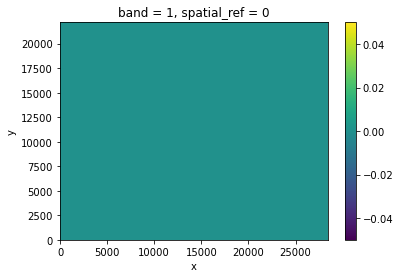

In [58]:
ds.plot()